This notebook covers the runs with three polystyrene (DVB-crosslinked) particles and one polyethylene particle. 

In [1]:

import numpy as np
import pprint
import math
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import re
from re import split


Let's set some variables:

In [2]:
excludedvids=[] # videos which, due to errors in data collection, should not be used

And define some functions:

In [3]:
%run asymm-particle_funs.ipynb

Legacy code for including old results

In [4]:

def parser_arr_old(filename):
    # returns array of all traansitions and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    with open(filename) as textfile:
        line = textfile.readline()
        while line:
            if 'Processing' in line:
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                vidnum = int(vidnum)
                line = textfile.readline()
            if 'T threshold'in line:
                thresh_set = []
                for word in line.split():
                    try:
                        thresh_set.append(float(word))
                    except ValueError:
                        pass
                    
                line = textfile.readline()
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word))
                        except ValueError:
                            pass
                                        
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        thresholds.append(thresh_set)
                        vidnums=[]
                        vidarrs.append([[], vidnums])
                    else:
                        pass    
                    
                    line = textfile.readline()
                    if '[[' in line:
                        arr = np.zeros((mlen,mlen))
                        linenums = [int(s) for s in  re.findall(r'\d+',line)]
                        arr[0,:] = linenums

                        line = textfile.readline()  

                        linenums = [int(s) for s in  re.findall(r'\d+',line)]
                        arr[1,:] = linenums

                        vidarrs[-1][0].append(arr)
                        vidarrs[-1][1].append(vidnum)
                    else:
                        print("missing array")
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
                    
                
            
    textfile.close()
    return([np.array(thresholds), vidarrs]) 

Set the colors for the output plots -> first color is for Top state, second is for c-shape.

In [5]:
cols = [ 'red', 'orange' ] #Top, C-state

Now to read in some data and check that everything works. This is the newerstyrene data. I'm printing the length of the three pieces of data we collected (the thresholds, the transitions, and the time in state), and also the first array, representing the transitions for every video in run 1. 

In [6]:
trans_runs= parser_arr(glob('./wash*styrene.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs]) # should be the same length = the number of runs
test = trans_runs[1][0]
pprint.pprint(test[0]) # every video array for the first run 


[3, 3, 3]
[array([[ 0.,  2.],
       [ 2., 10.]]),
 array([[ 3.,  0.],
       [ 1., 81.]]),
 array([[ 1.,  1.],
       [ 2., 20.]]),
 array([[ 0.,  0.],
       [ 0., 30.]]),
 array([[10.,  8.],
       [ 8., 16.]]),
 array([[ 1.,  3.],
       [ 3., 14.]]),
 array([[ 5.,  8.],
       [ 8., 27.]]),
 array([[3., 3.],
       [3., 5.]]),
 array([[0., 0.],
       [0., 7.]]),
 array([[0., 0.],
       [0., 6.]])]


This is the old styrene data, which was thought to be glass data.

In [7]:
trans_runs_old= parser_arr_old(glob('./output wash*trans.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs_old]) # should be the same length = the number of runs
test = trans_runs_old[1][0] 
pprint.pprint(test[0]) # Every video array for the first run



[8, 8]
[array([[2., 2.],
       [2., 3.]]),
 array([[ 6.,  1.],
       [ 0., 28.]]),
 array([[2., 2.],
       [1., 3.]]),
 array([[0., 1.],
       [1., 1.]]),
 array([[1., 2.],
       [2., 4.]]),
 array([[  2.,   4.],
       [  4., 137.]]),
 array([[ 2.,  2.],
       [ 3., 34.]]),
 array([[ 0.,  0.],
       [ 0., 10.]]),
 array([[0., 1.],
       [1., 7.]]),
 array([[0., 0.],
       [0., 4.]]),
 array([[ 0.,  0.],
       [ 0., 13.]]),
 array([[ 3.,  9.],
       [10., 24.]])]


Gettig the actual observed transitions (and times) into matrices.

In [8]:
expt_list = [trans_runs, trans_runs_old]
exptnames = ["Second Styrene Experiment", "First \"glass\" Experiment"]
vidstoexclude = [excludedvids, excludedvids]
stored_y_values = {} # the transition matrices, by 
times = {}
c_threshes = {exptname: [] for exptname in exptnames} 
t_threshes = {exptname: [] for exptname in exptnames} 

for expt, exptname, excludedvids in zip(expt_list, exptnames, vidstoexclude):   
    print(exptname)
    y_vals = {}
    t_vals = {}
    run_indices = list(range(len(expt[0]))) # for all the videos in trans_runs
    criteria = []  #the strings to print to label each run
    for runindex in run_indices:
        trans_threshes = expt[0][runindex]
        t_threshes[exptname].append(trans_threshes[0])
        c_threshes[exptname].append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))

        vidarrs = np.array(expt[1][runindex][0]) 
        vidnums = expt[1][runindex][1]
        print("Run number {}, thresholds {}".format(runindex, criteria[-1]))
        print('videos recorded', vidnums)

        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids] # index of good videos in vidnums list
        vidnums = [vidnums[x] for x in allowed_inds]
        vidarrs = vidarrs[allowed_inds]   # Choosing arrays in vidarrs corresponding to correct videos from vidnums        
        if len(expt[1][runindex]) > 2:
            timarrs = np.array(expt[1][runindex][2]) 
            timarrs = timarrs[allowed_inds]
        else:
            timarrs = []            
        print('videos used in calculations', vidnums)

        if len(vidarrs) == len(vidnums):
            vidindices = list(range(len(vidarrs))) # need to iterate over every video that's good
        else:
            print("Something's wrong with the indexing!")

        # collect list of probability transitions; one per video    
        percent_pairs = {}
        transarrlists = {}
        for vidind in vidindices: 
            T_obb = vidarrs[vidind] # observed transition matrix for this video
            print('\nMatrix observed for video {}: \n'.format(vidind), T_obb)
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))]) # normailise each row s othe transitions sm to 1
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100 # convert to percentages
            print('Precentages:', counts)
            percent_pairs[vidind] = counts
            if len(timarrs) != 0:
                Ti_obb = timarrs[vidind]
                print("Times:", Ti_obb)
                transarrlists[vidind] =  Ti_obb
        y_vals[runindex]= percent_pairs
        if bool(transarrlists):
            t_vals[runindex] = transarrlists
        print('\nTotal transitions: ',np.sum(vidarrs), "\n Sum of all transition matrices:\n", np.sum(vidarrs, axis=0), '\n\n') 
    stored_y_values[exptname] = y_vals
    if bool(t_vals):
        times[exptname] = t_vals
#stored_y_values = np.array(stored_y_values)

    

Second Styrene Experiment
Run number 0, thresholds 30,20
videos recorded [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
videos used in calculations [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Matrix observed for video 0: 
 [[ 0.  2.]
 [ 2. 10.]]
Precentages: [ 8.33333333 91.66666667]
Times: [[[list([]) list([1221, 1914])]
  [list([4722, 10421])
   list([5349, 337, 4651, 1447, 3712, 14180, 2103, 838, 1248, 8234])]]

 [[list([]) list([871, 443])]
  [list([3593, 9117])
   list([5241, 278, 4536, 1351, 3601, 12983, 774, 766, 96, 8098])]]

 [[list([]) list([350, 1471])]
  [list([1129, 1304])
   list([108, 59, 115, 96, 111, 1197, 1329, 72, 1152, 136])]]]

Matrix observed for video 1: 
 [[ 3.  0.]
 [ 1. 81.]]
Precentages: [50.6097561 49.3902439]
Times: [[[list([264, 2238, 1823]) list([])]
  [list([134])
   list([307, 732, 183, 146, 122, 107, 186, 92, 111, 170, 190, 193, 86, 131, 208, 179, 199, 196, 88, 89, 193, 248, 353, 221, 701, 193, 406, 132, 278, 196, 273, 144, 260, 811, 104, 105, 116, 134, 212, 222, 139, 98, 251, 19

 [ 7. 23.]]
Precentages: [24.16666667 75.83333333]

Total transitions:  288.0 
 Sum of all transition matrices:
 [[ 17.  18.]
 [ 18. 235.]] 


Run number 3, thresholds 40,15
videos recorded [0, 1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9]
videos used in calculations [0, 1, 10, 11, 2, 3, 4, 5, 6, 7, 8, 9]

Matrix observed for video 0: 
 [[2. 2.]
 [2. 3.]]
Precentages: [45. 55.]

Matrix observed for video 1: 
 [[ 4.  1.]
 [ 0. 20.]]
Precentages: [40. 60.]

Matrix observed for video 2: 
 [[1. 2.]
 [1. 2.]]
Precentages: [33.33333333 66.66666667]

Matrix observed for video 3: 
 [[0. 1.]
 [1. 1.]]
Precentages: [25. 75.]

Matrix observed for video 4: 
 [[1. 2.]
 [2. 4.]]
Precentages: [33.33333333 66.66666667]

Matrix observed for video 5: 
 [[  1.   4.]
 [  4. 104.]]
Precentages: [11.85185185 88.14814815]

Matrix observed for video 6: 
 [[ 1.  2.]
 [ 3. 30.]]
Precentages: [21.21212121 78.78787879]

Matrix observed for video 7: 
 [[0. 0.]
 [0. 8.]]
Precentages: [  0. 100.]

Matrix observed for video 8: 

Combining the data from the two different experiments to get observed probabilities by video. 

In [9]:
exptnum = 0 # to to separate the labeling for the runs
bignum = 100 # to separate the labeling for the runs
vidprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt] # 3 dicts, one per run
    for runnum, rundict in exptdicts.items():
        keys = rundict.keys() # vifdeo number of run
        for key in keys: # a video number
            vidnumkey = exptnum + key
            if vidnumkey not in vidprops.keys():
                vidprops[vidnumkey] = rundict[key]                
            else:
                vidprops[vidnumkey] = np.vstack((vidprops[vidnumkey], rundict[key]))
    exptnum = exptnum + bignum

#Got to double check!
keys = vidprops.keys()
vidsums = [] #sum all the probabilities 
for key in keys:
    allprobs = vidprops[key]
    print("Collected all probabilities for video  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    vidsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
vidsums = np.array(vidsums)
vidinds = list(range(len(keys)))    
print("\nShape of total data array", np.shape(vidsums))
    

Collected all probabilities for video  0: 
[[ 8.33333333 91.66666667]
 [14.28571429 85.71428571]
 [14.28571429 85.71428571]]
And summed and averaged all probabilities:
[12.3015873 87.6984127]

Collected all probabilities for video  1: 
[[50.6097561  49.3902439 ]
 [52.17391304 47.82608696]
 [52.08333333 47.91666667]]
And summed and averaged all probabilities:
[51.62233416 48.37766584]

Collected all probabilities for video  2: 
[[29.54545455 70.45454545]
 [ 5.55555556 94.44444444]
 [ 6.25       93.75      ]]
And summed and averaged all probabilities:
[13.78367003 86.21632997]

Collected all probabilities for video  3: 
[[  0.         100.        ]
 [ 40.19607843  59.80392157]
 [ 41.66666667  58.33333333]]
And summed and averaged all probabilities:
[27.2875817 72.7124183]

Collected all probabilities for video  4: 
[[44.44444444 55.55555556]
 [10.71428571 89.28571429]]
And summed and averaged all probabilities:
[27.57936508 72.42063492]

Collected all probabilities for video  5: 
[[21.32


This is what the transition probabilities look like, for each video, counting all runs (pairs of thresholds) together. 

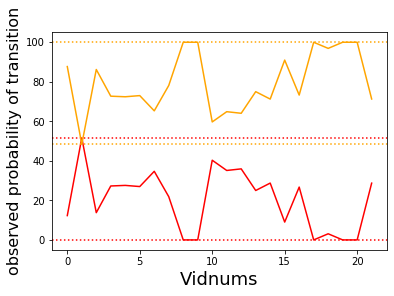

In [10]:

# Print probabilitie sby video
plotter(vidinds, vidsums.T, cols, 'Vidnums')


Now to get the observed probabilities, by stability threshold (the number of consecutive frames which must be registered as a state before the state changes; any break in the chain resets the counting). 

In [11]:
cprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items():
        c_thresh = c_threshes[expt][runnum] #Where the selection magic happens
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if c_thresh not in cprops.keys():
                cprops[c_thresh] = rundict[key]                
            else:
                cprops[c_thresh] = np.vstack((cprops[c_thresh], rundict[key]))
            #print("List of transition pairs for video {}: \n{}".format(key, vidprops[vidnumkey]))

#Got to double check!
keys = sorted(cprops.keys())
csums = [] #sum all the probabilities 
for key in keys:
    allprobs = cprops[key]
    print("Collected all probabilities for c_threshold  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    csums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
csums = np.array(csums)
cinds = keys  
print("C_thresholds used:", cinds)
print("\nShape of total data array", np.shape(csums))




Collected all probabilities for c_threshold  15.0: 
[[ 45.          55.        ]
 [ 42.85714286  57.14285714]
 [ 37.5         62.5       ]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 18.08510638  81.91489362]
 [ 29.05405405  70.94594595]
 [  0.         100.        ]
 [  6.25        93.75      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 27.20588235  72.79411765]
 [ 45.          55.        ]
 [ 40.          60.        ]
 [ 33.33333333  66.66666667]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 11.85185185  88.14814815]
 [ 21.21212121  78.78787879]
 [  0.         100.        ]
 [  7.14285714  92.85714286]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 29.74137931  70.25862069]
 [ 45.          55.        ]
 [  0.         100.        ]
 [ 33.33333333  66.66666667]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 12.63157895  87.36842105]
 [ 21.83908046  78.16091954]
 [  0.         100.        ]
 [  8.33333333  91.6

As you see, the proportions are not very sensitive to this. 

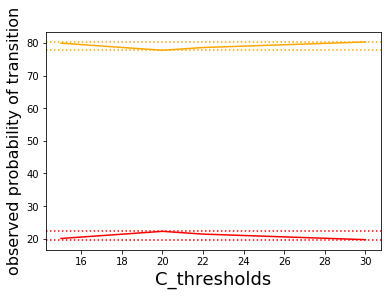

In [12]:
plotter(cinds, csums.T, cols, 'C_thresholds')

Now to get how the transition probabilities vary wrt the transition sthreshold (how many frames does a raft remain broken for before it is classified as broken. This only applies in the case of transitions to the same state as the original).

In [13]:
tprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items():
        t_thresh = t_threshes[expt][runnum]
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if t_thresh not in tprops.keys():
                tprops[t_thresh] = rundict[key]                
            else:
                tprops[t_thresh] = np.vstack((tprops[t_thresh], rundict[key]))
            #print("List of transition pairs for video {}: \n{}".format(key, vidprops[vidnumkey]))

#Got to double check!
keys = sorted(tprops.keys())
tsums = [] #sum all the probabilities 
for key in keys:
    allprobs = tprops[key]
    print("Collected all arrays for T_threshold  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    tsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
tsums = np.array(tsums)
tinds = keys  
print("T_thresholds used:", tinds)
print("\nShape of total data array", np.shape(tsums))



Collected all arrays for T_threshold  30.0: 
[[  8.33333333  91.66666667]
 [ 50.6097561   49.3902439 ]
 [ 29.54545455  70.45454545]
 [  0.         100.        ]
 [ 44.44444444  55.55555556]
 [ 21.32352941  78.67647059]
 [ 30.65934066  69.34065934]
 [ 43.75        56.25      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 45.          55.        ]
 [ 42.85714286  57.14285714]
 [ 37.5         62.5       ]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 18.08510638  81.91489362]
 [ 29.05405405  70.94594595]
 [  0.         100.        ]
 [  6.25        93.75      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 27.20588235  72.79411765]
 [ 37.5         62.5       ]
 [ 43.75        56.25      ]
 [ 41.66666667  58.33333333]
 [ 25.          75.        ]
 [ 35.          65.        ]
 [ 11.42857143  88.57142857]
 [ 30.          70.        ]
 [  0.         100.        ]
 [  0.         100.        ]
 [  0.         100.        ]
 [  0.         100.        

Within the threshold range used, the probabilities are insensitive to this. 

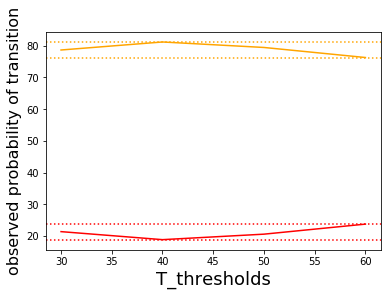

In [14]:
plotter(tinds, tsums.T, cols, 'T_thresholds')

One weakenss is an inability to recognize transitions that occur by unorthodox motions like sliding of one particle from the edge through the middle (which ahs been observed), if the final state isn't different than the original. 

Finally, for each pair of thresholds, the observed probailities of transition. 

In [15]:
rprops = {}
exptnum = 0
bignum = 100
# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items(): 
        t_thresh = t_threshes[expt][runnum]
        c_thresh = c_threshes[expt][runnum]
        runkey = (t_thresh, c_thresh)
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if runkey not in rprops.keys():
                rprops[runkey] = rundict[key]                
            else:
                rprops[runkey] = np.vstack((rprops[runkey], rundict[key]))
    exptnum += bignum

#Got to double check!
keys = sorted(rprops.keys())
rsums = [] #sum all the probabilities 
for key in keys:
    allprobs = rprops[key]
    print("Collected all arrays for run  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    rsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
rsums = np.array(rsums)
rinds = list(range(len(keys)))  
print("Runs done:",keys)
print("\nShape of total data array", np.shape(rsums))



Collected all arrays for run  (30.0, 15.0): 
[[ 45.          55.        ]
 [ 42.85714286  57.14285714]
 [ 37.5         62.5       ]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 18.08510638  81.91489362]
 [ 29.05405405  70.94594595]
 [  0.         100.        ]
 [  6.25        93.75      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 27.20588235  72.79411765]]
And summed and averaged all probabilities:
[22.02379325 77.97620675]

Collected all arrays for run  (30.0, 20.0): 
[[  8.33333333  91.66666667]
 [ 50.6097561   49.3902439 ]
 [ 29.54545455  70.45454545]
 [  0.         100.        ]
 [ 44.44444444  55.55555556]
 [ 21.32352941  78.67647059]
 [ 30.65934066  69.34065934]
 [ 43.75        56.25      ]
 [  0.         100.        ]
 [  0.         100.        ]]
And summed and averaged all probabilities:
[22.86658585 77.13341415]

Collected all arrays for run  (30.0, 22.0): 
[[ 37.5         62.5       ]
 [ 43.75        56.25      ]
 [ 41.66666667  58.33333333

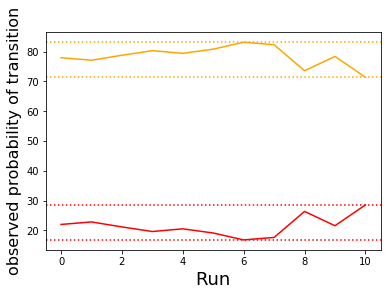

In [16]:
plotter(rinds, rsums.T, cols, 'Run') #max,min for each state

These matrices give what transition probabilities we expect if the particles were to move along th eperimeter of thr raft, in a 'hinging' motion. The moving particle is on the long axis (as they have fewer contacts),
and it uses a neighbouring particle on the short ais as its hinge. For each state, the particles on either end of the long 
axis are allowed to move either clockwise or counterclockwise, with no bias in either direction. Bonds broken in order to move are not included. 


In [17]:
alphas = np.linspace(0, 5, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    print('\nalpha = %s' %i)
    T_expected_broad = np.asarray([[4*i, 2*(i + 1)],
     [4, 2*(i+1)]])
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    print('\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    x1.append(evec_one[0])
    x2.append(evec_one[1])


alpha = 0.0

 [[0.   1.  ]
 [0.67 0.33]]

alpha = 0.05

 [[0.09 0.91]
 [0.66 0.34]]

alpha = 0.1

 [[0.15 0.85]
 [0.65 0.35]]

alpha = 0.15000000000000002

 [[0.21 0.79]
 [0.63 0.37]]

alpha = 0.2

 [[0.25 0.75]
 [0.62 0.37]]

alpha = 0.25

 [[0.29 0.71]
 [0.62 0.38]]

alpha = 0.30000000000000004

 [[0.32 0.68]
 [0.61 0.39]]

alpha = 0.35000000000000003

 [[0.34 0.66]
 [0.6  0.4 ]]

alpha = 0.4

 [[0.36 0.64]
 [0.59 0.41]]

alpha = 0.45

 [[0.38 0.62]
 [0.58 0.42]]

alpha = 0.5

 [[0.4  0.6 ]
 [0.57 0.43]]

alpha = 0.55

 [[0.42 0.58]
 [0.56 0.44]]

alpha = 0.6000000000000001

 [[0.43 0.57]
 [0.56 0.44]]

alpha = 0.65

 [[0.44 0.56]
 [0.55 0.45]]

alpha = 0.7000000000000001

 [[0.45 0.55]
 [0.54 0.46]]

alpha = 0.75

 [[0.46 0.54]
 [0.53 0.47]]

alpha = 0.8

 [[0.47 0.53]
 [0.53 0.47]]

alpha = 0.8500000000000001

 [[0.48 0.52]
 [0.52 0.48]]

alpha = 0.9

 [[0.49 0.51]
 [0.51 0.49]]

alpha = 0.9500000000000001

 [[0.49 0.51]
 [0.51 0.49]]

alpha = 1.0

 [[0.5 0.5]
 [0.5 0.5]]

alpha =

The bold lines show the expected probailities of transitioning to each state, with a given ratio of bond strength, where alpha represents the ratio of a styrene-ethylene bond over a styrene-styrene bond. The inverse of this is called the (relative) styrene bond strength. 
This probability the same as the proportion of transitions from the state, at steady state.

The dashed lines represent the observed probabilities of transitions. As there is no interesection between the dashed and bold lines, this model does not capture the data. 

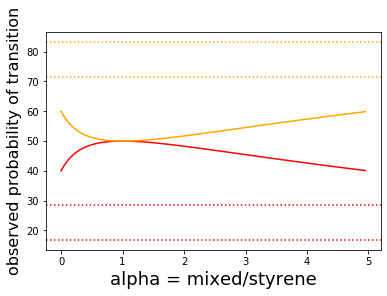

In [18]:

xs = np.vstack((x1, x2))
eig_plotter(alphas, xs, cols, 'alpha = mixed/styrene', rsums.T) #using rsum = runs for ranges

This is the same as before, but the bond formed (weighted by their strenghts) are divided by the bonds broken, which provides as cost to motion. 
In the 3-polystyren case, this does capture the data, indicated by both pairs of coloured lines crossing at about the same alpha value. 

This means tha the transition statistics we see are possible using only hinge mtion (although both types of motion do inf act occur). 

In other cases, such as some 3-polyethylene runs, it is not possible to reocver the statistics using only hinge mption. 



In [19]:
alphas = np.linspace(0, 12, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    print('\nalpha = %s' %i)
    T_expected_broad = np.asarray([[2, i + 1],
     [4/(i+1), 2]])
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    print('\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    x1.append(evec_one[0])
    x2.append(evec_one[1])



alpha = 0.0

 [[0.67 0.33]
 [0.67 0.33]]

alpha = 0.12

 [[0.64 0.36]
 [0.64 0.36]]

alpha = 0.24

 [[0.62 0.38]
 [0.62 0.38]]

alpha = 0.36

 [[0.6 0.4]
 [0.6 0.4]]

alpha = 0.48

 [[0.57 0.43]
 [0.57 0.43]]

alpha = 0.6

 [[0.56 0.44]
 [0.56 0.44]]

alpha = 0.72

 [[0.54 0.46]
 [0.54 0.46]]

alpha = 0.84

 [[0.52 0.48]
 [0.52 0.48]]

alpha = 0.96

 [[0.51 0.49]
 [0.51 0.49]]

alpha = 1.08

 [[0.49 0.51]
 [0.49 0.51]]

alpha = 1.2

 [[0.48 0.52]
 [0.48 0.52]]

alpha = 1.3199999999999998

 [[0.46 0.54]
 [0.46 0.54]]

alpha = 1.44

 [[0.45 0.55]
 [0.45 0.55]]

alpha = 1.56

 [[0.44 0.56]
 [0.44 0.56]]

alpha = 1.68

 [[0.43 0.57]
 [0.43 0.57]]

alpha = 1.7999999999999998

 [[0.42 0.58]
 [0.42 0.58]]

alpha = 1.92

 [[0.41 0.59]
 [0.41 0.59]]

alpha = 2.04

 [[0.4 0.6]
 [0.4 0.6]]

alpha = 2.16

 [[0.39 0.61]
 [0.39 0.61]]

alpha = 2.28

 [[0.38 0.62]
 [0.38 0.62]]

alpha = 2.4

 [[0.37 0.63]
 [0.37 0.63]]

alpha = 2.52

 [[0.36 0.64]
 [0.36 0.64]]

alpha = 2.6399999999999997

 [[0.35 0

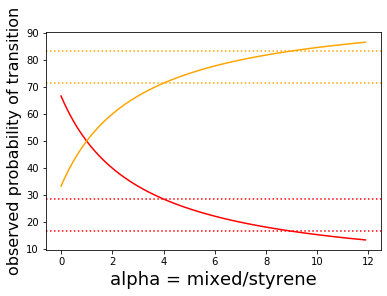

In [20]:

xs = np.vstack((x1, x2))
eig_plotter(alphas, xs, cols, 'alpha = mixed/styrene', rsums.T) #using rsum = runs for ranges

Breaking apart !!

In [21]:
alphas = np.linspace(0, 12, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    t = (2/((1+i)*(2+2*i))+
         4*i/((1+i)*(2+2*i)*(4+2*i))+
          2*i/((1+i)*(4+2*i)))
    #print(bm)
    c = (2*i/((1+i)*(4+2*i))+
          i*(2+2*i)/((1+i)*(4+2*i)))
    
    T_expected_broad = np.asarray([[t, c],
     [t, c]])
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    print('\n', np.around(T_expected_broad_norm, 3))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    x1.append(evec_one[0])
    x2.append(evec_one[1])



 [[1. 0.]
 [1. 0.]]

 [[0.893 0.107]
 [0.893 0.107]]

 [[0.806 0.194]
 [0.806 0.194]]

 [[0.735 0.265]
 [0.735 0.265]]

 [[0.676 0.324]
 [0.676 0.324]]

 [[0.625 0.375]
 [0.625 0.375]]

 [[0.581 0.419]
 [0.581 0.419]]

 [[0.543 0.457]
 [0.543 0.457]]

 [[0.51 0.49]
 [0.51 0.49]]

 [[0.481 0.519]
 [0.481 0.519]]

 [[0.455 0.545]
 [0.455 0.545]]

 [[0.431 0.569]
 [0.431 0.569]]

 [[0.41 0.59]
 [0.41 0.59]]

 [[0.391 0.609]
 [0.391 0.609]]

 [[0.373 0.627]
 [0.373 0.627]]

 [[0.357 0.643]
 [0.357 0.643]]

 [[0.342 0.658]
 [0.342 0.658]]

 [[0.329 0.671]
 [0.329 0.671]]

 [[0.316 0.684]
 [0.316 0.684]]

 [[0.305 0.695]
 [0.305 0.695]]

 [[0.294 0.706]
 [0.294 0.706]]

 [[0.284 0.716]
 [0.284 0.716]]

 [[0.275 0.725]
 [0.275 0.725]]

 [[0.266 0.734]
 [0.266 0.734]]

 [[0.258 0.742]
 [0.258 0.742]]

 [[0.25 0.75]
 [0.25 0.75]]

 [[0.243 0.757]
 [0.243 0.757]]

 [[0.236 0.764]
 [0.236 0.764]]

 [[0.229 0.771]
 [0.229 0.771]]

 [[0.223 0.777]
 [0.223 0.777]]

 [[0.217 0.783]
 [0.217 0.783]]



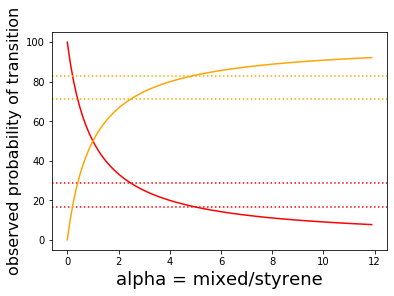

In [22]:

xs = np.vstack((x1, x2))
eig_plotter(alphas, xs, cols, 'alpha = mixed/styrene', rsums.T) #using rsum = runs for ranges

The proportion of hinge motion varies with different experiments, and there's not a way to know how much hinging vs breaking apart 
takes place, unless there is an independent constraint on the bond strengths. 
This graph shows the flexibility one has in modeling the transitiosn by chosing some linear combination of the break apart and hinging matrices. 

the far left of this graph shows the mixed bond / styrene-styrene bodn inferred if there was only breaking apart, and the far left shows for only hinging. 

In the event of the green line crossing the x axis, that is the largest proportion of hingin motion which could occur, and at this point it is as if the glass bond was infinitely larger than the mixed bond. 
Then, the data looks as isf the glass particles never moved, and the polystyrene particles moved freely around their perimeter 
when hinging takes place, and likewise that glass wa infinitely more strongly binding than ethylene when the particles reassembled.  
This happens in some 3-polyethylene runs, when it's not possible to use more than [] percent hinging to explian the data. 

Acceptable ranges for top state, c-state proportions: [(16.830792043750723, 28.571428571428573), (71.42857142857143, 83.16920795624928)]


Text(0.5, 0, 'proprtion of hinge motion')

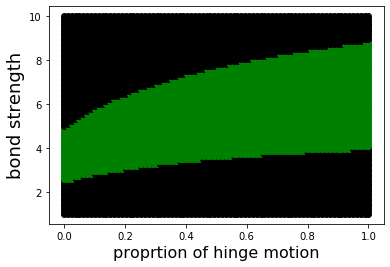

In [23]:
#narrow observations array
fig, ax = plt.subplots()
alphas = np.linspace(1, 10, 80)
ratios = np.linspace(0, 1, 80)
tolerances = [minmax(i) for i in rsums.T]
print("Acceptable ranges for top state, c-state proportions:", tolerances)


for i in alphas:
    for r in ratios:
        #print('\nalpha = %s' %i)
        #print(tm)
        t = (2/((1+i)*(2+2*i))+
         4*i/((1+i)*(2+2*i)*(4+2*i))+
          2*i/((1+i)*(4+2*i)))
        #print(bm)
        c = (2*i/((1+i)*(4+2*i))+
              i*(2+2*i)/((1+i)*(4+2*i)))

        T2 = np.asarray([[t, c],
         [t, c]])
        T1 = np.asarray([[2, i + 1],
         [4/(i+1), 2]])
        T_expected_narrow = r*T1 + (1-r)*T2
        #print(T_expected_narrow)
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        test = all((evec_one[i]>= tolerances[i][0] and evec_one[i]<= tolerances[i][1])  for i in range(len(evec_one)))
        if test:
            col = "green"
        else:
            col = "k"
        plt.plot(r, i, c=col, marker='o')
plt.ylabel('bond strength', fontsize=18)
plt.xlabel('proprtion of hinge motion', fontsize=16)

Now to collect data on the ttransitions times, by run index. 

In [24]:
rtimes = {}
exptnum = 0
bignum = 100
# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(times.keys()): #per experiment
    exptdicts = times[expt]    
    for runnum, rundict in exptdicts.items(): #the collection of results in a single run of an eperiment
        t_thresh = t_threshes[expt][runnum]
        c_thresh = c_threshes[expt][runnum]
        runkey = (t_thresh, c_thresh) #the trial 
        keys = rundict.keys() # video numbers of run
        for key in keys: #evry video
            if runkey not in rtimes.keys():
                rtimes[runkey] = rundict[key]   
            else:
                rtimes[runkey] = end_append(rtimes[runkey], rundict[key])
    exptnum += bignum
     
#Got to double check!
keys = sorted(rtimes.keys())
for key in keys:
    alltimes = rtimes[key]
    print("\nCollected all transition times for run  {}: \n{}".format(key, alltimes))


Collected all transition times for run  (30.0, 20.0): 
[[[array([ 264., 2238., 1823., 2860., 1984.,   70.,  162.,  254.,  378.,
        284.,  327.,  278., 3358., 1908.,  248., 2250.,  782., 2858.,
       3563.,  552., 1470.,  401., 1024.])
   array([1221., 1914., 2584., 6578.,  657.,  508.,  126., 5284.,  513.,
        504., 4494., 1940., 1198., 1293., 4158.,  311.,  322., 1562.,
       3797., 1287., 2291.,  882., 1326., 7170., 3020.])]
  [array([ 4722., 10421.,   134.,  1223.,  1451.,   301.,   574.,   296.,
         676.,  1832.,   225.,   734.,  2846.,   222.,   932.,   783.,
         479.,   789.,  1283.,   990.,  1369.,   224., 14037.,  1249.,
        1075.,   168.,  1534.])
   array([ 5349,   337,  4651,  1447,  3712, 14180,  2103,   838,  1248,
        8234,   307,   732,   183,   146,   122,   107,   186,    92,
         111,   170,   190,   193,    86,   131,   208,   179,   199,
         196,    88,    89,   193,   248,   353,   221,   701,   193,
         406,   132,   278


Times: 
Frames between transitions
means,  [1756.0, 927.0]
vars,  [2789002.0, 3348762.0]
[[264.0, 2238.0, 1823.0, 2860.0, 1984.0, 70.0, 162.0, 254.0, 378.0, 284.0, 327.0, 278.0, 3358.0, 1908.0, 248.0, 2250.0, 782.0, 2858.0, 3563.0, 552.0, 1470.0, 401.0, 1024.0, 1221.0, 1914.0, 2584.0, 6578.0, 657.0, 508.0, 126.0, 5284.0, 513.0, 504.0, 4494.0, 1940.0, 1198.0, 1293.0, 4158.0, 311.0, 322.0, 1562.0, 3797.0, 1287.0, 2291.0, 882.0, 1326.0, 7170.0, 3020.0], [4722.0, 10421.0, 134.0, 1223.0, 1451.0, 301.0, 574.0, 296.0, 676.0, 1832.0, 225.0, 734.0, 2846.0, 222.0, 932.0, 783.0, 479.0, 789.0, 1283.0, 990.0, 1369.0, 224.0, 14037.0, 1249.0, 1075.0, 168.0, 1534.0, 5349, 337, 4651, 1447, 3712, 14180, 2103, 838, 1248, 8234, 307, 732, 183, 146, 122, 107, 186, 92, 111, 170, 190, 193, 86, 131, 208, 179, 199, 196, 88, 89, 193, 248, 353, 221, 701, 193, 406, 132, 278, 196, 273, 144, 260, 811, 104, 105, 116, 134, 212, 222, 139, 98, 251, 192, 135, 85, 253, 125, 314, 248, 127, 224, 323, 189, 160, 972, 291, 14

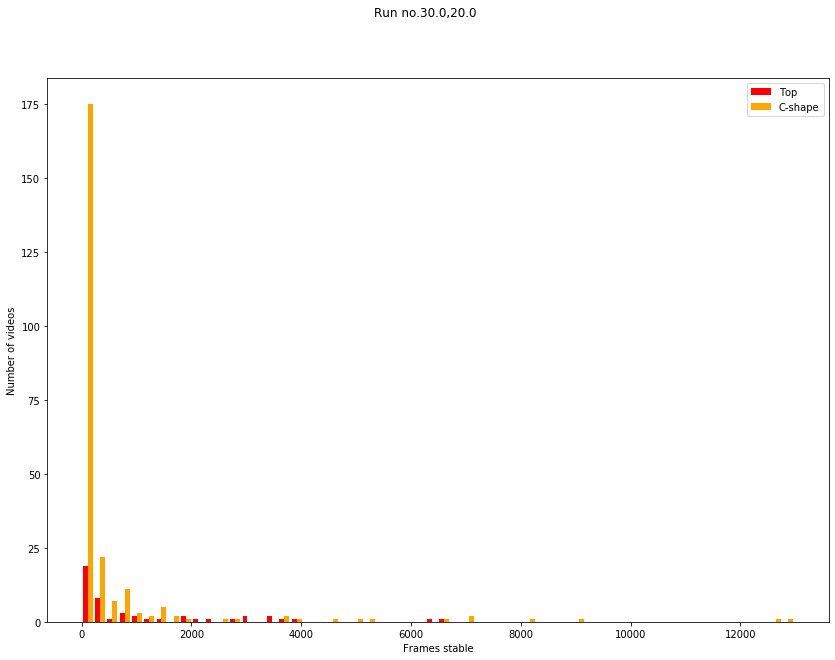

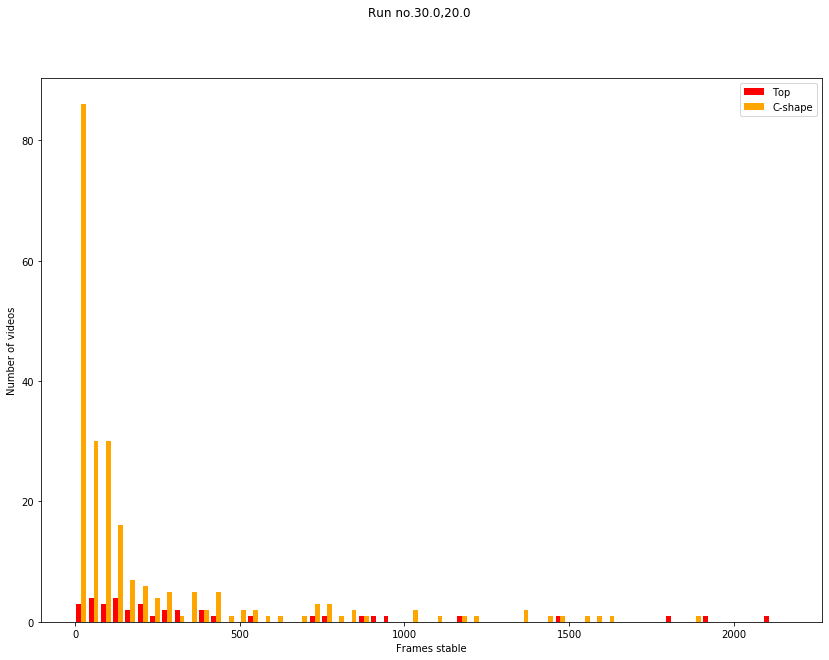

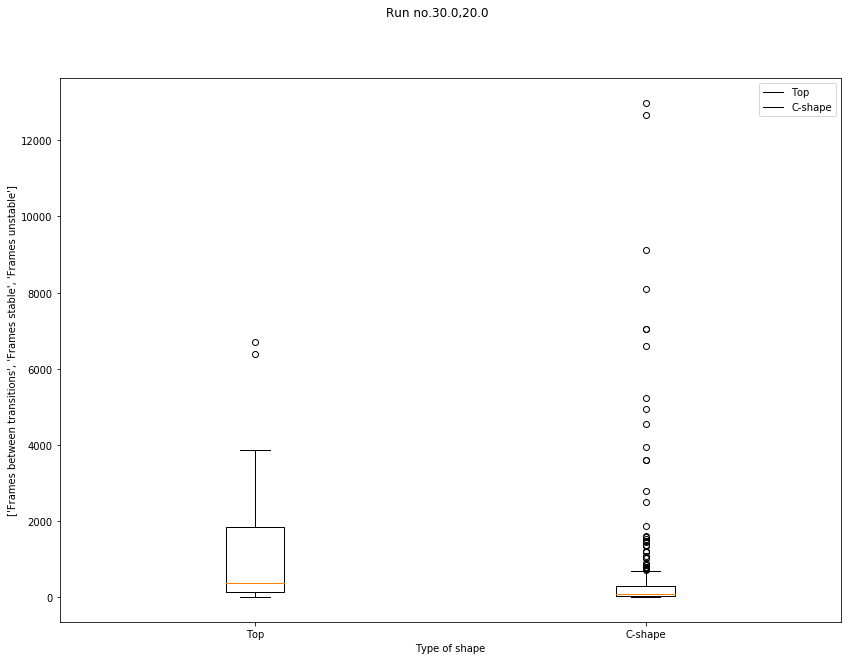

In [25]:
import seaborn 
labels = ["Top", "C-shape"]

def binnerseq(seq, nbins, discardfrac):
    #control the binning of the output by chunking a portion of it into one big bin at the end
    maximum = np.nanmax([x for y in seq for x in y])
    rang = maximum
    bins = list(np.linspace(0, np.round(maximum/discardfrac), nbins-1))
    #bins.append(maximum) 
    return np.array(bins)



    

timenames = ["Frames between transitions", "Frames stable", "Frames unstable"]
keys = [keys[0]]
for run in keys: 
    times = rtimes[run]
    title = "Run no." + str(run[0]) + "," + str(run[1])
    # for each run, separate the three times
    total_time, stable_time, unstable_time = times
    tind = 1 #only the stable time, please
    print("\nTimes: ")
    for time, timename in zip(times, timenames):
        print(timename)
        time = [[trans for col in row for trans in col] for row in time]
        print('means, ',[np.round(np.nanmean(row)) for row in time])   #This is a pair of means, one for trans from each state  
        print('vars, ',[np.round(np.nanvar(row)) for row in time])
        print(time, '\n')
    time = times[tind]  # choose a time to measure
    time = [[trans for col in row for trans in col] for row in time]
    timename = timenames[tind]
    #times, timenames = times[1:2], timenames[1:2]
    
    
    fig, ax = plt.subplots(figsize = (14, 10)) #All the data
    fig.suptitle(title)   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  60, 1))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    fig, ax = plt.subplots(figsize = (14, 10)) #Zoomed in plot
    fig.suptitle(title)   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  60, 6))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    
    fig, ax = plt.subplots( figsize = (14, 10))
    fig.suptitle(title)  
    ax.set_prop_cycle(color=cols)
    ax.boxplot(time, labels = labels)####
    ax.set_ylabel(timenames)
    ax.set_xlabel("Type of shape")
    ax.legend(labels)

The decay curve is probably because short transitions are being cut off as they are below the current thresholds; the raft evidently isn't always stable for as long as the stability thresholds for these runs.The videos should eb reanalysed with lower thresholds, bearing in mind that there is an error from thresholds which are too low, since the classification does fluctuate especially for active clusters which someimes deviate from a perfect diamond wthout transitioning.

A reason intrinsic to the data why transitiosn might be prferentially short is that short ransitions happen when the raft is full of energy, and when it calms down there are infrequent transitions with long stable times. 
